# Task 2: Data Visualisation

**Q1.a**

**producer is producing each data per 10 seconds, so in order to get 10 data to plot the graph, we will need roughlt 100seconds, therefore i decided to change to start plotting once it received 5 data**

**Import Libraries**

In [92]:
# import statements
from time import sleep
import json
from kafka3 import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt

**Plotting the graph**

<IPython.core.display.Javascript object>


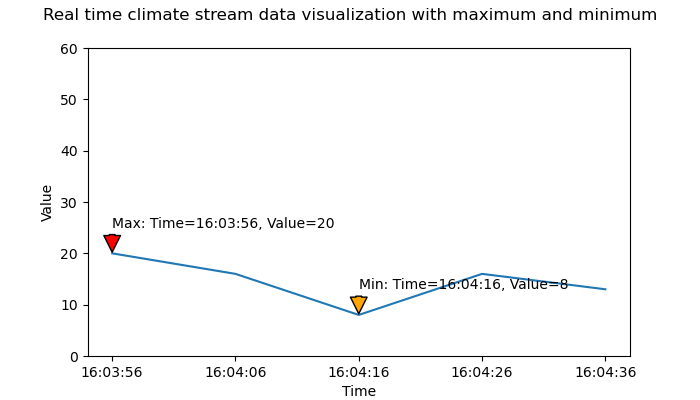

/tmp/ipykernel_7428/2280784835.py:94: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close('all')


In [94]:
# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

# set topic and ip address into variables
topic = 'climate'
hostip = "192.168.1.27" 

# to find the maximum value in the plot for each window
def find_max(x, y, ax = None):
    max_y = max(y)
    pos_x = y.index(max_y)
    max_x = x[pos_x]
    text = 'Max: Time={}, Value={}'.format(max_x, max_y)
    if not ax:
        ax=plt.gca()
    
    #shrink=0.05: The value 0.05 indicates that the arrowhead will be 5% of the total arrow length.
    ax.annotate(text, xy=(max_x, max_y), xytext=(max_x, max_y+5), arrowprops=dict(facecolor='red', shrink=0.05),)

# to find the minimum value in the plot for each window
def find_min(x, y, ax = None):
    min_y = min(y)
    pos_x = y.index(min_y)
    min_x = x[pos_x]
    text = 'Min: Time={}, Value={}'.format(min_x, min_y)
    if not ax:
        ax=plt.gca()
        
    #xytext = location of text, min_y+5 because we wont wan the text overlap with the point we wan it to be higher so +5
    ax.annotate(text, xy=(min_x, min_y), xytext=(min_x, min_y+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

# Connect kafka consumer to susbcribe to the producer and retreive the data
def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=20000, # stop iteration if no message after 20 sec
                                   bootstrap_servers=[f'{hostip}:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 7
        height = 4
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real time climate stream data visualization with maximum and minimum') # giving figure a title
        ax.set_xlabel('Created Time')
        ax.set_ylabel('Air Temperature Value')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        
        # container for x and y values
        x, y = [], []
          
        for val in consumer:
            data = val.value.decode('utf-8')
            
            #convert to dic object
            data = json.loads(data)
            
            # as i have 3 producer using the same topic, hence i needed if else in case all 3 producer are running
            if data["producer"] == 'climate_streaming': 
                
                x.append(str(data['cre_date_time']))
                y.append(int(data['air_temperature_celcius']))

                # we start plotting only when we have 5 data points
                if len(y) >= 5:
                    ax.clear()
                    ax.plot(x, y)
                    ax.set_xlabel('Time')
                    ax.set_ylabel('Value')
                    ax.set_ylim(0,60) 
                    ax.set_yticks([0,10,20,30,40,50,60])
                    find_max(x,y)
                    find_min(x,y)
                    fig.canvas.draw()
                    x.pop(0) # removing the item in the first position
                    y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

**Q2**

In [95]:
# import libraries needed
import json
import pandas as pd
from pprint import pprint
from datetime import datetime
import folium
import pymongo
from pymongo import MongoClient

#### Making connection with MongoDB

In [96]:
client = MongoClient('192.168.1.27', 27017) # 27017 number of ports

**check all databases**

In [97]:
# to get all the databases in client 
result = client.list_database_names()
print(result)

['admin', 'config', 'fit3182_assignment_db', 'fit3182_db', 'local']


**connect to fit3182_assignment_db**

In [98]:
db = client.fit3182_assignment_db

**list all collections**

In [99]:
print(db.list_collection_names())

['climate_hotspot', 'hotspot', 'climate', 'clihot']


**connect to climate_hotspot**

In [100]:
clihot = db.climate_hotspot

**Q2.a**

**find fire records** <br>
First, search for all fire records in database and group them based on their date.<br>
Based on FAQ, every 2 seconds = 24/5 hours

In [109]:
fire_records = clihot.aggregate([{"$unwind":"$fire_event"},{"$group":{"_id":"$fire_event.datetime", "Number_of_fire":{"$sum":1}}},{"$project": {"newdate": 1,"Number_of_fire": 1}}])

After that, append the result into a list

In [110]:
data = []

for i in fire_records:
    data.append(i)

**plot the bar graph**

<IPython.core.display.Javascript object>


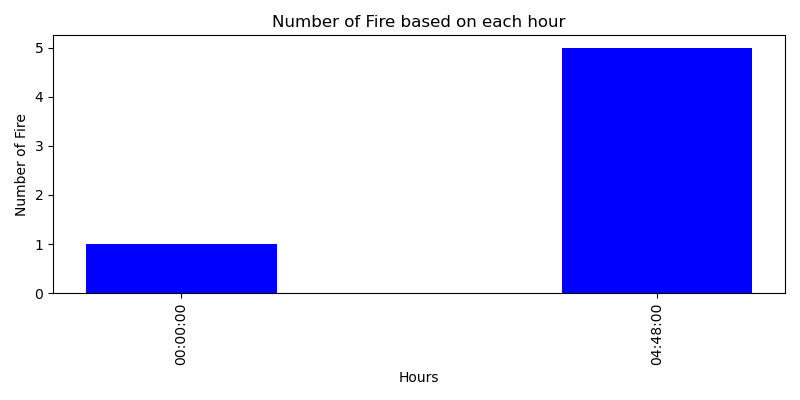

In [113]:
x_b,y_b=[],[]
for i in data:
    x_b.append(str(i['_id']))
    y_b.append(int(i['Number_of_fire']))

# edit figure size
fig = plt.figure(figsize = (8, 4))

# create bar plot
plt.bar(x_b,y_b, color = "blue",width=0.4)

plt.xlabel("Hours")

# rotate x axis ticks as it's too long to see
plt.xticks(rotation=90)
plt.ylabel("Number of Fire")
plt.title("Number of Fire based on each hour")

# to make sure the plot stay in the layout
plt.tight_layout()
plt.show()
    

**Q2.b**

**Find all the fire event locations locations**

In [104]:
locations=[]
for value in clihot.find({}):
    if value["fire_event"] != []:
        for location in value["fire_event"]:
            
            # append colour 
            if value["cause_fire_event"] == "natural":
                color = "blue"
            elif value["cause_fire_event"] == "other":
                color = "red"
            locations.append([color,location["latitude"],location["longitude"],value["air_temperature_celcius"],location["surface_temperature_celcius"],value["relative_humidity"],location["confidence"]])
    

In [105]:
print(locations)

[['red', -36.7215, 144.1037, 9, 60, 41.9, 86], ['blue', -36.0966, 142.3635, 24, 61, 56.8, 86], ['red', -37.4485, 143.5041, 20, 54, 60.8, 81], ['red', -37.452, 148.115, 8, 77, 43.1, 68], ['red', -37.9318, 143.2083, 16, 44, 53.6, 69], ['red', -36.353, 144.5977, 13, 38, 47.1, 50]]


**initialize the map at Victoria, Australia**<br>
The given latitude and longnitude are belongs to Victoria, Australia 

In [106]:
fomap = folium.Map(location=[-37.812015244225677, 144.951471202974], zoom_start=15)

**append the data into the map**

In [107]:
for location in locations:
    folium.Marker(location=(location[1],location[2]),icon=folium.Icon(color=location[0]), popup=f"air_temperature={location[3]:.2f}, <br>surface_temperature={location[4]:.2f}, <br>relative_humidity={location[5]:.2f},<br>confidence={location[6]:.2f}").add_to(fomap)

In [108]:
fomap